# Who is the GOAT (Greatest Of All Time) in men's tennis?

The below analysis attempts to analyse the level of competition great tennis players needed to face at the time they played tennis and investigates who reached the highest level of tennis.

To do this analysis, I will apply the Elo rating system created by Élő Árpád, a Hungarian-born American physicist. This provides a basis for comparison between players of different eras. Usual argument with the success of palyers, that they might not face as tough competition as others playing at different times in the open era. With the ELO rating, we can evaluate how they would do against players they could never face in their prime.

In [2]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('ATP.csv')
df = df[df['tourney_date'] != 'tourney_date']
df['winner_id'] = pd.to_numeric(df['winner_id'])
df['loser_id'] = pd.to_numeric(df['loser_id'])

/Users/petersinka/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,5,6,7,8,9,12,14,15,16,17,18,19,22,24,25,26,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Most majors by players

One way to answer the GOAT question is that who has the most major tournament wins. If we look at this, we have a clean winner with Roger Federer. Usual argument against this approach is that competition was much lower this time as earlier (Laver era, Borg-McEnroe rivalry or Sampras vs. Aggassi).

So we apply ELO rating that provides a comparison between the different eras.

In [3]:
# Most majors
gs_winner_df = df[(df['tourney_level'] == 'G') & (df['round'] == 'F')]
grouped = gs_winner_df.groupby('winner_name').count().sort_values('winner_id', ascending= False).ix[:,0]
grouped

winner_name
Roger Federer            18
Rafael Nadal             14
Pete Sampras             14
Novak Djokovic           12
Bjorn Borg               11
Ivan Lendl                8
Andre Agassi              8
Jimmy Connors             8
Mats Wilander             7
John Mcenroe              7
Stefan Edberg             6
Boris Becker              6
John Newcombe             5
Rod Laver                 5
Jim Courier               4
Ken Rosewall              4
Guillermo Vilas           4
Gustavo Kuerten           3
Jan Kodes                 3
Arthur Ashe               3
Andy Murray               3
Stanislas Wawrinka        3
Patrick Rafter            2
Lleyton Hewitt            2
Sergi Bruguera            2
Stan Smith                2
Marat Safin               2
Yevgeny Kafelnikov        2
Johan Kriek               2
Ilie Nastase              2
Albert Costa              1
Richard Krajicek          1
Yannick Noah              1
Thomas Muster             1
Thomas Johansson          1
Andres G

#### Create initial player ELO table

This ELO rating does not differentiate between different tournament levels,

In [4]:
# List of all players in the data
winner_names = df[['winner_name','winner_id']].drop_duplicates().set_index('winner_id')
loser_names = df[['loser_name','loser_id']].drop_duplicates().rename(index=str, columns={"loser_name": "winner_name", "loser_id": "winner_id"}).set_index('winner_id')

In [5]:
# List of all players in the data
winner_names = df[['winner_name','winner_id']].drop_duplicates()
loser_names = df[['loser_name','loser_id']].drop_duplicates().rename(index=str, columns={"loser_name": "winner_name", "loser_id": "winner_id"})

player_unique_list = pd.concat([winner_names, loser_names])

player_unique_list['winner_id'] = pd.to_numeric(player_unique_list['winner_id'])

player_unique_list = player_unique_list.drop_duplicates(['winner_name','winner_id']).set_index('winner_id')

player_unique_list['elo_score'] = 1000

#### Create time series from the data

In [6]:
from dateutil.parser import parse

In [7]:
# Parse timestamp from tourney date
df['timestamp'] = df.loc[:,'tourney_date'].apply(lambda x: parse(str(x)))

K-s based on Tourney level:
G: major
D: Davis Cup
M: Major tournament
C: Challanger
F: Final
A: regular tournament

In [8]:
# Setting timestamp as index
df = df.set_index(df['timestamp'])

In [9]:
columns_needed_for_elo = [
    'tourney_id',
    'tourney_name',
    'draw_size',
    'tourney_level',
    'winner_id',
    'winner_name',
    'loser_id',
    'loser_name',
    'score',
    'best_of',
    'round'
]

In [10]:
elo_df = df[columns_needed_for_elo]

In [11]:
len(elo_df)

163965

#### Calculating score difference to reward straight set wins in ELO.

In [12]:
def score_diff(score, best_of):
    if ((len(score.split()) == 3) and (best_of == 5)) or ((len(score.split()) == 2) and (best_of == 3)):
        return 1.75
    elif (len(score.split()) == 4) and (best_of == 5):
        return 1.5
    else:
        return 1

In [13]:
elo_df['score_diff'] = elo_df.apply(lambda x: score_diff(str(x['score']), x['best_of']), axis = 1)

/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Calculate ELO ratings

In [14]:
def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def elo(old, expected, score, score_diff, k=30):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 32)
    :param score_diff: calculated score diff for result
    """
    return old + k * score_diff * (score - expected)

In [15]:
def elo_calc(row):
    prev_elo_winner = player_unique_list.loc[row['winner_id'],'elo_score']
    prev_elo_loser = player_unique_list.loc[row['loser_id'],'elo_score']
    
    exp_win = expected(prev_elo_winner, prev_elo_loser)
    exp_lose = expected(prev_elo_loser, prev_elo_winner)
    
    elo_winner = elo(prev_elo_winner, exp_win, 1, row['score_diff'])
    elo_loser = elo(prev_elo_loser, exp_lose, 0, row['score_diff'])
    
    player_unique_list.loc[row['winner_id'],'elo_score'] = elo_winner
    player_unique_list.loc[row['loser_id'],'elo_score'] = elo_loser
    
    #return [elo_winner, elo_loser]

    return pd.Series({'elo_winner': elo_winner, 'elo_loser':elo_loser}) 

In [16]:
elo_scores = elo_df.apply(lambda x: elo_calc(x), axis = 1)

In [17]:
elo_df['elo_loser'] = elo_scores.iloc[:,0]
elo_df['elo_winner'] = elo_scores.iloc[:,1]

/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

#### GS winner comparison

In [19]:
grouped[grouped > 2].index.values.tolist()

['Roger Federer',
 'Rafael Nadal',
 'Pete Sampras',
 'Novak Djokovic',
 'Bjorn Borg',
 'Ivan Lendl',
 'Andre Agassi',
 'Jimmy Connors',
 'Mats Wilander',
 'John Mcenroe',
 'Stefan Edberg',
 'Boris Becker',
 'John Newcombe',
 'Rod Laver',
 'Jim Courier',
 'Ken Rosewall',
 'Guillermo Vilas',
 'Gustavo Kuerten',
 'Jan Kodes',
 'Arthur Ashe',
 'Andy Murray',
 'Stanislas Wawrinka']

In [20]:
gs_winner_list = grouped[grouped > 2].index.values.tolist()

The below plot shows the ELO rating of all the players in the open era who won 2 or more majors. It turns out that both Bjorn Borg and John McEnroe reached higher rating as Roger Federer who has the most major titles. However, this ELO rating does not reward for winning on majors vs. winning on any tournament. In the next analysis, we take into account the tournament level.

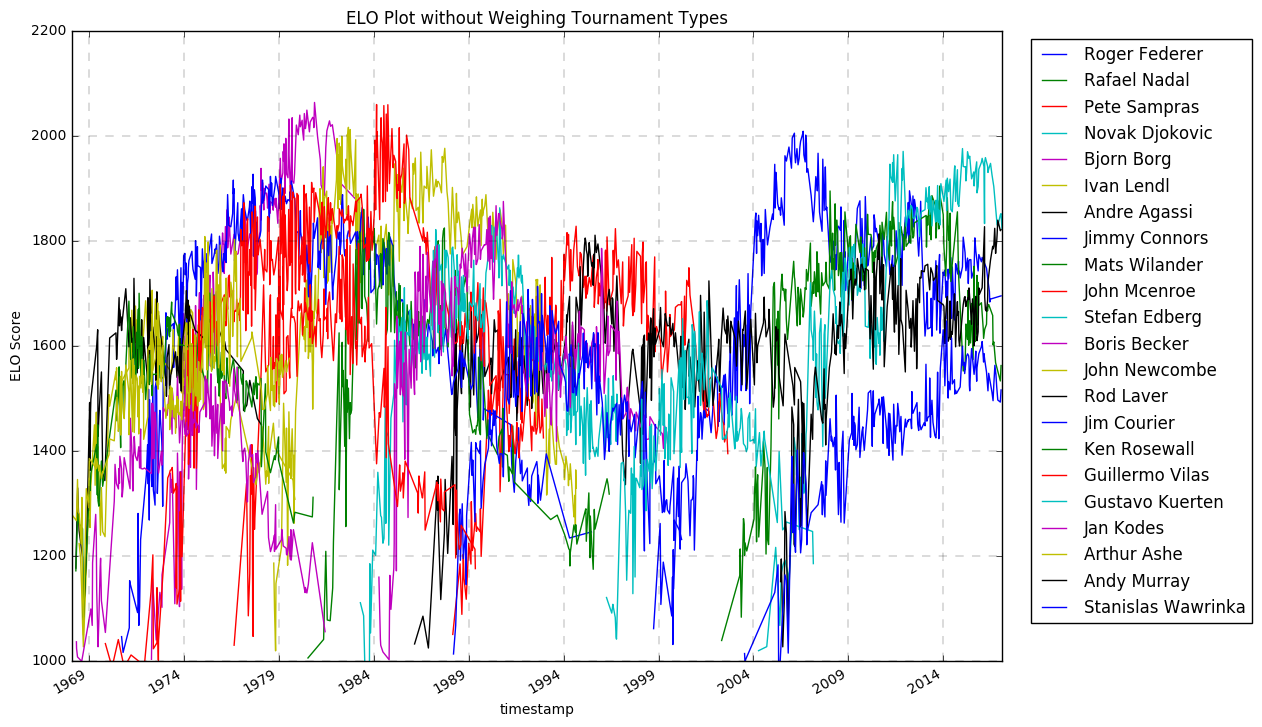

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.set_title('ELO Plot without Weighing Tournament Types')
ax.set_xlabel('Year')
ax.set_ylabel('ELO Score')
ax.set_ylim([1000, 2200])

for player in gs_winner_list:
    player_inst = elo_df[elo_df['winner_name'] == player]['elo_winner']
    player_inst = player_inst.groupby(level=0).mean()
    player_inst.plot(label= player)

plt.grid(b=True, which='major', color='k', linestyle='--', linewidth = .2)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1))

## Taking majors into account with K-score weighing

K-s based on Tourney level:
G: major
D: Davis Cup
M: Major tournament
C: Challanger
F: Final
A: regular tournament

In this implementation, we give higher weight to Majors, ATP finals and Master events.

In [22]:
def elo_calc_with_k(row):
    prev_elo_winner = player_unique_list.loc[row['winner_id'],'elo_score']
    prev_elo_loser = player_unique_list.loc[row['loser_id'],'elo_score']
    
    exp_win = expected(prev_elo_winner, prev_elo_loser)
    exp_lose = expected(prev_elo_loser, prev_elo_winner)
    
    if row['tourney_level'] == 'G':
        k = 50
    elif row['tourney_level'] == 'F':
        k = 40
    elif row['tourney_level'] == 'M':
        k = 35
    else:
        k = 30
    
    elo_winner = elo(prev_elo_winner, exp_win, 1, row['score_diff'], k)
    elo_loser = elo(prev_elo_loser, exp_lose, 0, row['score_diff'], k)
    
    player_unique_list.loc[row['winner_id'],'elo_score'] = elo_winner
    player_unique_list.loc[row['loser_id'],'elo_score'] = elo_loser
    
    #return [elo_winner, elo_loser]

    return pd.Series({'elo_winner': elo_winner, 'elo_loser':elo_loser}) 

In [23]:
elo_df_gs = df[columns_needed_for_elo]
elo_df_gs['score_diff'] = elo_df_gs.apply(lambda x: score_diff(str(x['score']), x['best_of']), axis = 1)
elo_scores_gs = elo_df_gs.apply(lambda x: elo_calc_with_k(x), axis = 1)
elo_df_gs['elo_loser'] = elo_scores_gs.iloc[:,0]
elo_df_gs['elo_winner'] = elo_scores_gs.iloc[:,1]

/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/petersinka/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [24]:
gs_winner_list_5_or_more = grouped[grouped >= 5].index.values.tolist()

In this plot, we show only players with 5 or more majors. We can see that Roger Federer's and also Novak's ELO rating is increasing to the level of Borg and McEnroe; hoever, it can be clearly seen that competition in the Borg McEnroe era was condierably higher with Lendl, Connors, Wilander and Co; this can explain the lower number of majros for these players. Djokovic recent run leading up to the 2016 Roland Garros with the non-calendar Grand Slam does reach the Borg, McEnroe, Federer heights. Nadal and especially Sampras, despite their 14 major wins, does not reach the highest rating level.

One interesting fact to keep the records straight: the dataset starts from 1968, the start of the open era. This is the middle of the career of the great Rod Laver. As seen above, he has only 5 major wins as per the data out of the 11 during his career. He completed the calendar-year Grand Slam twice which has not happened since then.

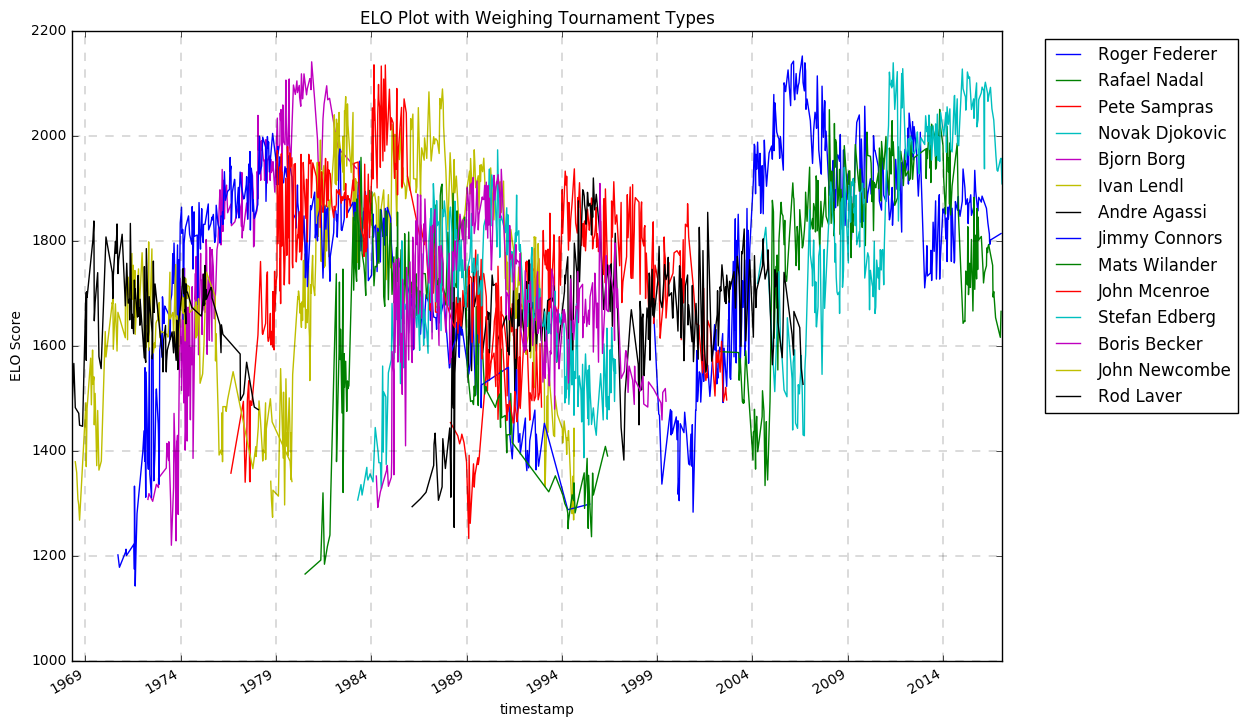

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.set_title('ELO Plot with Weighing Tournament Types')
ax.set_xlabel('Year')
ax.set_ylabel('ELO Score')
ax.set_ylim([1000, 2200])

for player in gs_winner_list_5_or_more:
    player_inst = elo_df_gs[elo_df_gs['winner_name'] == player]['elo_winner']
    player_inst = player_inst.groupby(level=0).mean()
    player_inst.plot(label= player)

plt.grid(b=True, which='major', color='k', linestyle='--', linewidth = .2)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1))

All players with 3+ major wins.

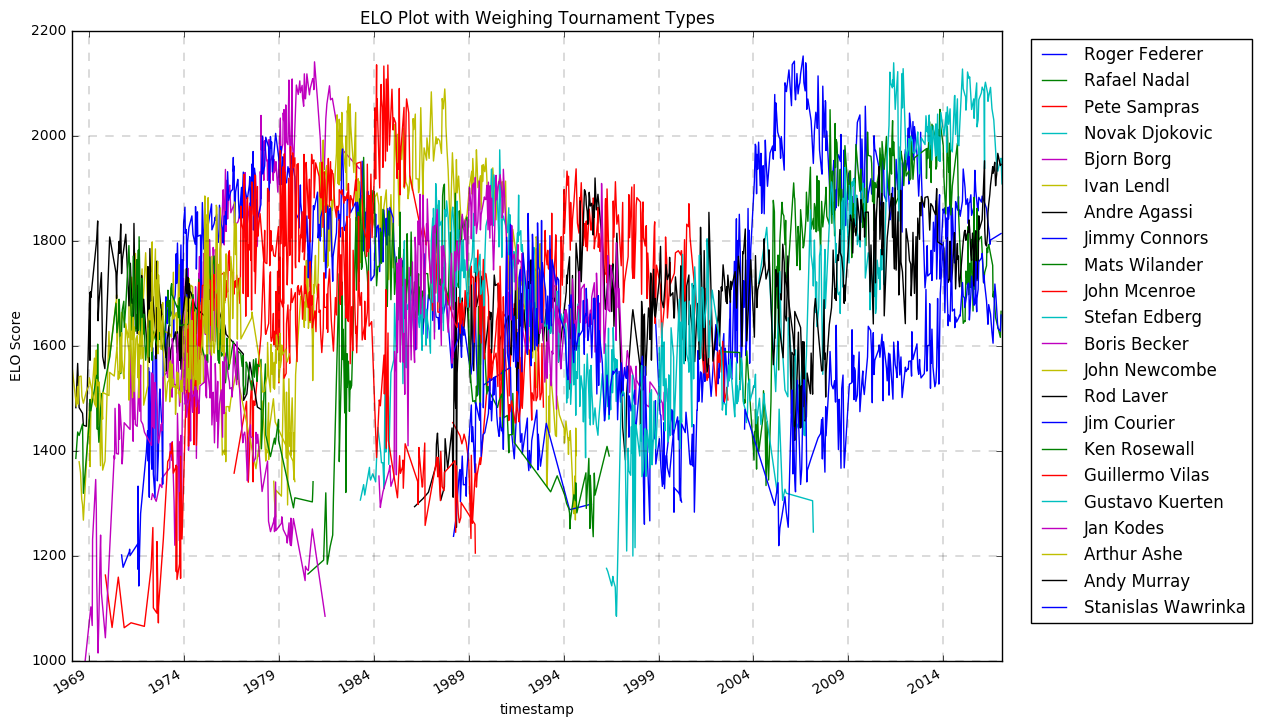

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.set_title('ELO Plot with Weighing Tournament Types')
ax.set_xlabel('Year')
ax.set_ylabel('ELO Score')
ax.set_ylim([1000, 2200])

for player in gs_winner_list:
    player_inst = elo_df_gs[elo_df_gs['winner_name'] == player]['elo_winner']
    player_inst = player_inst.groupby(level=0).mean()
    player_inst.plot(label= player)

plt.grid(b=True, which='major', color='k', linestyle='--', linewidth = .2)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1))

In [38]:
elo_df_gs.groupby('winner_name')['elo_winner'].max().sort_values(ascending = False).head(30)

winner_name
Roger Federer            2151.705671
Novak Djokovic           2142.021284
Bjorn Borg               2140.728951
John Mcenroe             2134.887965
Ivan Lendl               2100.107686
Rafael Nadal             2054.858404
Jimmy Connors            2008.665311
Stefan Edberg            1980.655296
Andy Murray              1974.441027
Mats Wilander            1958.852378
Pete Sampras             1947.805479
Boris Becker             1945.193219
Andre Agassi             1937.578799
Guillermo Vilas          1930.186628
Arthur Ashe              1888.973069
Juan Martin Del Potro    1875.825380
Lleyton Hewitt           1872.104299
Juan Carlos Ferrero      1867.225931
Thomas Muster            1865.180576
Vitas Gerulaitis         1857.657459
Jim Courier              1855.007875
David Nalbandian         1842.392399
Rod Laver                1838.702834
Robin Soderling          1838.625232
Ilie Nastase             1836.727935
Pat Cash                 1833.292998
Andy Roddick             1

References:
I used the below source for the ELO rating formulas:
https://github.com/rshk/elo